In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) #default size plot
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

#for auto-reload ext. modules
%load_ext autoreload
%autoreload 2

(-1, 1)

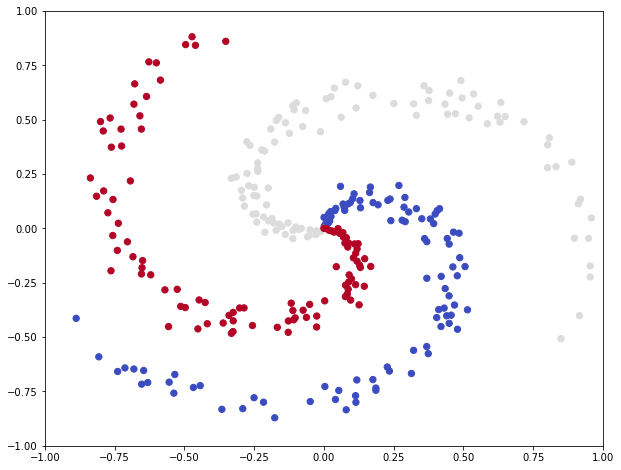

In [15]:
np.random.seed(0)
N = 100 #number of point per class
D = 2 #dimension
K = 3 #number of classes
X = np.zeros((N*K, D))
y = np.zeros(N*K, dtype='uint8')

for i in range(K): #xrange return object, range return list object
    ix = range(N*i, N*(i+1))
    r = np.linspace(0.0, 1, N) #radius
    t = np.linspace(i*4, (i+1)*4, N) + np.random.randn(N) * 0.2 #theta
    X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
    y[ix] = i
fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.coolwarm)
plt.xlim([-1, 1])
plt.ylim([-1, 1])
#fig.savefig('spiral_raw.png)

# Train a Softmax Linear Classifier

In [39]:
#initialize parameter randomly
W = np.random.randn(D, K) * 0.01
b = np.zeros((1, K))

#some hyperparameters
step_size = 1e-0
reg = 1e-3 #regulation strength

#compute the loss
num_examples = X.shape[0]
#gradient descent loop
for i in range(200):
    
    #evaluate class scores
    scores = np.dot(X, W) + b
    
    #compute class probabilities
    #get unnormalized probabilities
    exp_scores = np.exp(scores)
    #normalize them for each example
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    #compute the loss: avg. cross-entropy loss and regularization
    correct_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(correct_logprobs)/num_examples
    reg_loss = 0.5 * reg * np.sum(W * W)
    loss = data_loss + reg_loss
    if i % 10 == 0:
        print ("iteration %d: loss %f" % (i, loss))
        
    #compute the gradient of scores
    dscores = probs
    dscores[range(num_examples), y] -= 1
    dscores /= num_examples
    
    #backpropate the gradient to the parameter
    dW = np.dot(X.T, dscores)
    db = np.sum(dscores, axis=0, keepdims=True)
    
    dW += reg * W #regulization gradient
    
    #perform a parameter update
    W += -step_size * dW
    b += -step_size * db

iteration 0: loss 1.099498
iteration 10: loss 0.918095
iteration 20: loss 0.851841
iteration 30: loss 0.822498
iteration 40: loss 0.807672
iteration 50: loss 0.799498
iteration 60: loss 0.794711
iteration 70: loss 0.791783
iteration 80: loss 0.789933
iteration 90: loss 0.788734
iteration 100: loss 0.787943
iteration 110: loss 0.787412
iteration 120: loss 0.787052
iteration 130: loss 0.786805
iteration 140: loss 0.786634
iteration 150: loss 0.786515
iteration 160: loss 0.786432
iteration 170: loss 0.786373
iteration 180: loss 0.786332
iteration 190: loss 0.786302


In [40]:
#evaluate training set accuracy
scores = np.dot(X, W) + b
predicted_class = np.argmax(scores, axis=1)
print ('training accuracy: %.2f' % (np.mean(predicted_class == y)))

training accuracy: 0.49


(-1.8881265923735315, 1.9518734076264719)

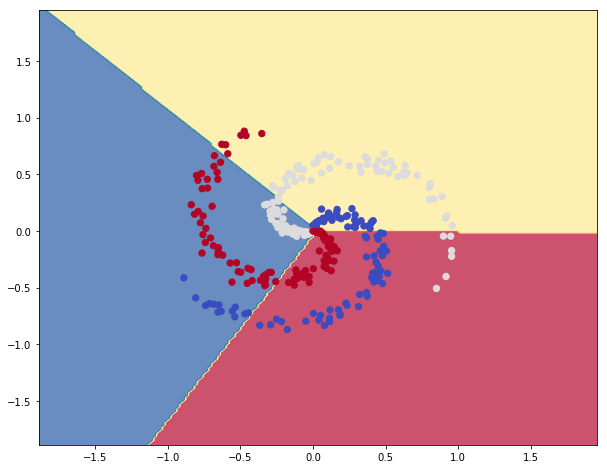

In [42]:
#plot the resulting classifier
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 0].min() - 1, X[:, 0].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.coolwarm)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#fig.savefig('spiral_linear.png')

# Train a Neural Network

In [44]:
#initialize parameters randomly
h = 100 #size of hidden layer
W = 0.01 * np.random.randn(D, h)
b = np.zeros((1, h))
W2 = 0.01 * np.random.randn(h, K)
b2 = np.zeros((1, K))

#some hyperparameters
step_size = 1e-0
reg = 1e-3

#gradient descent loop
num_examples = X.shape[0]
for i in range(10000):
    
    #evaluate class scores
    hidden_layer = np.maximum(0, np.dot(X, W) + b) #ReLU Activation
    scores = np.dot(hidden_layer, W2) + b2
    
    #compute the class probabilities
    exp_scores = np.exp(scores)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    #compute the loss: avg. cross-entropy loss and regularization
    correct_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(correct_logprobs)/num_examples
    reg_loss = 0.5 * reg * np.sum(W * W) + 0.5 * reg * np.sum(W2 * W2)
    loss = data_loss + reg_loss
    
    if i % 1000 == 0:
        print ("iteration %d: loss %f" % (i, loss))
        
    #compute the gradient on scores
    dscores = probs
    dscores[range(num_examples), y] -= 1
    dscores /= num_examples
    
    #backpropate the gradient to the parameters
    #first backprop into parameters W2 and b2
    dW2 = np.dot(hidden_layer.T, dscores)
    db2 = np.sum(dscores, axis=0, keepdims=True)
    
    #next backprop into hidden layer
    dhidden = np.dot(dscores, W2.T)
    
    #backprop the ReLU non-Linearity
    dhidden[hidden_layer <= 0] = 0
    
    #finally into W,b
    dW = np.dot(X.T, dhidden)
    db = np.sum(dhidden, axis=0, keepdims=True)
    
    #add regularization gradient contribution
    dW2 += reg * W2
    dW += reg * W
    
    #perform a parameter update
    W += -step_size * dW
    b += -step_size * db
    W2 += -step_size * dW2
    b2 += -step_size * db2

iteration 0: loss 1.098594
iteration 1000: loss 0.308455
iteration 2000: loss 0.283061
iteration 3000: loss 0.262346
iteration 4000: loss 0.256004
iteration 5000: loss 0.253131
iteration 6000: loss 0.250290
iteration 7000: loss 0.251142
iteration 8000: loss 0.264398
iteration 9000: loss 0.249440


In [45]:
#evaluate training set accuracy
hidden_layer = np.maximum(0, np.dot(X, W) + b)
scores = np.dot(hidden_layer, W2) +  b2
predicted_class = np.argmax(scores, axis=1)
print ('training accuracy: %.2f' % (np.mean(predicted_class == y)))

training accuracy: 0.99


(-1.8712034092398278, 1.8687965907601756)

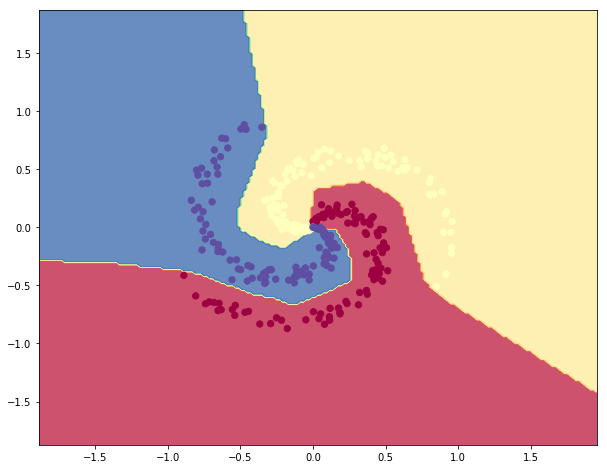

In [46]:
# plot the resulting classifier
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.maximum(0, np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b), W2) + b2
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#fig.savefig('spiral_net.png')